# **Deep Matrix Capsules on Salinas Scene**
### **Parameters:**

WindowSize: 25

No. of PCA Components: 30

No. of epochs: 10

Batch size: 64

Learning Rate: 3e-3

EM Iterations: 2

Architecture: [64, 32, 16, 16, 16]

Percentage of training data used: 50%

Percentage of validation data: 10% 

Percentage of testing data: 40%

## **Imports & Initialization**

In [1]:
from datetime import datetime
import math
from operator import truediv
import os
import pickle
import random
import time

import matplotlib.pyplot as plt
import numpy as np

import scipy.io as sio

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, cohen_kappa_score

import spectral

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn.modules.loss import _Loss

import warnings
warnings.filterwarnings('ignore')

In [2]:
seed = 3

# Making the model deterministic

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(seed)

torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## **Parameters**

### Dataset Parameters

In [3]:
test_ratio = 0.8
val_and_test_ratio = 0.5
windowSize = 25
batch_size = 32
no_of_PCA_components = 30

### Model Parameters

In [4]:
# model architecture
A, B, C, D = 64, 32, 16, 16

# EM Iterations
em_iters = 2

# PCA Componenets
pca_components = 30

# Epochs
epochs = 10

# Learning rate
lr = 3e-3

# Weight Decay
wd = 2e-7

# Test Intervals
test_intervals = 1

# Log Interval
log_interval = 10

# No. of classes
num_class = 16

## **Loading Data**

#### Defining Required Functions

In [5]:
def loadData():
    images = sio.loadmat('Data/Salinas/Salinas.mat')['salinas_corrected']
    labels = sio.loadmat('Data/Salinas/Salinas_gt.mat')['salinas_gt']
    return images, labels

In [6]:
def applyPCA(X, n_components=no_of_PCA_components, seed=seed):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=n_components, whiten=True, random_state=seed)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], n_components))
    return newX

In [7]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2*margin, X.shape[1] + 2*margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX [x_offset : X.shape[0] + x_offset, y_offset : X.shape[1] + y_offset, :] = X
    return newX

In [8]:
def createImageCubes(X, y, windowSize=windowSize, removeZeroLabels=True):
    margin = int((windowSize-1)/2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    
    patchesData = np.zeros((X.shape[0]*X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin: r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex += 1

    if removeZeroLabels:
        patchesData = patchesData[patchesLabels > 0, :, :, :]
        patchesLabels = patchesLabels[patchesLabels > 0]
        patchesLabels -= 1
    
    return patchesData, patchesLabels

In [9]:
def dataSplit(X, y, val_and_test_ratio=val_and_test_ratio, test_ratio=test_ratio, random_state=seed):
    X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, y, test_size=val_and_test_ratio, random_state=random_state, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=test_ratio, random_state=random_state, stratify=y_val_and_test)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
def convertToDataloader(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=batch_size, K=no_of_PCA_components):

    X_train = torch.Tensor(X_train)
    y_train = torch.Tensor(y_train)
    X_val = torch.Tensor(X_val)
    y_val = torch.Tensor(y_val)
    X_test = torch.Tensor(X_test)
    y_test = torch.Tensor(y_test)

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    return train_dataloader, val_dataloader, test_dataloader

#### Loading Data

In [11]:
X, y = loadData()

In [12]:
X = applyPCA(X)

In [13]:
X, y = createImageCubes(X, y)

In [14]:
X = X.transpose(0, 3, 1, 2)

In [15]:
X_train, y_train, X_val, y_val, X_test, y_test = dataSplit(X, y)

In [16]:
train_loader, val_loader, test_loader = convertToDataloader(X_train, y_train, X_val, y_val, X_test, y_test)

In [17]:
dataloaders = {'train': train_loader, 'valid': val_loader,'test': test_loader}

## **Model**

#### Capsule Network Model

In [18]:
class PrimaryCaps(nn.Module):
    
    def __init__(self, A=32, B=32, K=1, P=4, stride=1):
        super(PrimaryCaps, self).__init__()
        self.pose = nn.Conv2d(in_channels=A, out_channels=B*P*P,
                            kernel_size=K, stride=stride, bias=True)
        self.a = nn.Conv2d(in_channels=A, out_channels=B,
                            kernel_size=K, stride=stride, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        p = self.pose(x)
        a = self.a(x)
        a = self.sigmoid(a)
        out = torch.cat([p, a], dim=1)
        out = out.permute(0, 2, 3, 1)
        return out

In [19]:
class ConvCaps(nn.Module):

    def __init__(self, B=32, C=32, K=3, P=4, stride=2, iters=3,
                 coor_add=False, w_shared=False):
        super(ConvCaps, self).__init__()
        self.B = B
        self.C = C
        self.K = K
        self.P = P
        self.psize = P*P
        self.stride = stride
        self.iters = iters
        self.coor_add = coor_add
        self.w_shared = w_shared
        self.eps = 1e-8
        self._lambda = 1e-03
        self.ln_2pi = torch.cuda.FloatTensor(1).fill_(math.log(2*math.pi))

        self.beta_u = nn.Parameter(torch.zeros(C))
        self.beta_a = nn.Parameter(torch.zeros(C))

        self.weights = nn.Parameter(torch.randn(1, K*K*B, C, P, P))
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=2)

    def m_step(self, a_in, r, v, eps, b, B, C, psize):

        r = r * a_in
        r = r / (r.sum(dim=2, keepdim=True) + eps)
        r_sum = r.sum(dim=1, keepdim=True)
        coeff = r / (r_sum + eps)
        coeff = coeff.view(b, B, C, 1)

        mu = torch.sum(coeff * v, dim=1, keepdim=True)
        sigma_sq = torch.sum(coeff * (v - mu)**2, dim=1, keepdim=True) + eps

        r_sum = r_sum.view(b, C, 1)
        sigma_sq = sigma_sq.view(b, C, psize)
        cost_h = (self.beta_u.view(C, 1) + torch.log(sigma_sq.sqrt())) * r_sum

        a_out = self.sigmoid(self._lambda*(self.beta_a - cost_h.sum(dim=2)))
        sigma_sq = sigma_sq.view(b, 1, C, psize)

        return a_out, mu, sigma_sq

    def e_step(self, mu, sigma_sq, a_out, v, eps, b, C):

        ln_p_j_h = -1. * (v - mu)**2 / (2 * sigma_sq) \
                    - torch.log(sigma_sq.sqrt()) \
                    - 0.5*self.ln_2pi

        ln_ap = ln_p_j_h.sum(dim=3) + torch.log(a_out.view(b, 1, C))
        r = self.softmax(ln_ap)
        return r

    def caps_em_routing(self, v, a_in, C, eps):

        b, B, c, psize = v.shape
        assert c == C
        assert (b, B, 1) == a_in.shape

        r = torch.cuda.FloatTensor(b, B, C).fill_(1./C)
        for iter_ in range(self.iters):
            a_out, mu, sigma_sq = self.m_step(a_in, r, v, eps, b, B, C, psize)
            if iter_ < self.iters - 1:
                r = self.e_step(mu, sigma_sq, a_out, v, eps, b, C)

        return mu, a_out

    def add_pathes(self, x, B, K, psize, stride):

        b, h, w, c = x.shape
        assert h == w
        assert c == B*(psize+1)
        oh = ow = int(((h - K )/stride)+ 1)
        idxs = [[(h_idx + k_idx) \
                for k_idx in range(0, K)] \
                for h_idx in range(0, h - K + 1, stride)]
        x = x[:, idxs, :, :]
        x = x[:, :, :, idxs, :]
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous()
        return x, oh, ow

    def transform_view(self, x, w, C, P, w_shared=False):

        b, B, psize = x.shape
        assert psize == P*P

        x = x.view(b, B, 1, P, P)
        if w_shared:
            hw = int(B / w.size(1))
            w = w.repeat(1, hw, 1, 1, 1)

        w = w.repeat(b, 1, 1, 1, 1)
        x = x.repeat(1, 1, C, 1, 1)
        v = torch.matmul(x, w)
        v = v.view(b, B, C, P*P)
        return v

    def add_coord(self, v, b, h, w, B, C, psize):

        assert h == w
        v = v.view(b, h, w, B, C, psize)
        coor = torch.arange(h, dtype=torch.float32) / h
        coor_h = torch.cuda.FloatTensor(1, h, 1, 1, 1, self.psize).fill_(0.)
        coor_w = torch.cuda.FloatTensor(1, 1, w, 1, 1, self.psize).fill_(0.)
        coor_h[0, :, 0, 0, 0, 0] = coor
        coor_w[0, 0, :, 0, 0, 1] = coor
        v = v + coor_h + coor_w
        v = v.view(b, h*w*B, C, psize)
        return v

    def forward(self, x):
        b, h, w, c = x.shape
        if not self.w_shared:
            x, oh, ow = self.add_pathes(x, self.B, self.K, self.psize, self.stride)

            p_in = x[:, :, :, :, :, :self.B*self.psize].contiguous()
            a_in = x[:, :, :, :, :, self.B*self.psize:].contiguous()
            p_in = p_in.view(b*oh*ow, self.K*self.K*self.B, self.psize)
            a_in = a_in.view(b*oh*ow, self.K*self.K*self.B, 1)
            v = self.transform_view(p_in, self.weights, self.C, self.P)

            p_out, a_out = self.caps_em_routing(v, a_in, self.C, self.eps)
            p_out = p_out.view(b, oh, ow, self.C*self.psize)
            a_out = a_out.view(b, oh, ow, self.C)
            out = torch.cat([p_out, a_out], dim=3)
        else:
            assert c == self.B*(self.psize+1)
            assert 1 == self.K
            assert 1 == self.stride
            p_in = x[:, :, :, :self.B*self.psize].contiguous()
            p_in = p_in.view(b, h*w*self.B, self.psize)
            a_in = x[:, :, :, self.B*self.psize:].contiguous()
            a_in = a_in.view(b, h*w*self.B, 1)

            v = self.transform_view(p_in, self.weights, self.C, self.P, self.w_shared)

            if self.coor_add:
                v = self.add_coord(v, b, h, w, self.B, self.C, self.psize)

            _, out = self.caps_em_routing(v, a_in, self.C, self.eps)

        return out

In [20]:
class CapsNet(nn.Module):

    def __init__(self, A=32, B=32, C=32, D=32, E=10, K=3, P=4, iters=3):
        super(CapsNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=pca_components, out_channels=A,
                               kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(num_features=A, eps=0.001,
                                 momentum=0.1, affine=True)
        self.relu1 = nn.ReLU(inplace=False)
        self.primary_caps = PrimaryCaps(A, B, 1, P, stride=1)
        self.conv_caps1 = ConvCaps(B, C, K, P, stride=2, iters=iters)
        self.conv_caps2 = ConvCaps(C, D, K, P, stride=1, iters=iters)
        self.class_caps = ConvCaps(D, E, 1, P, stride=1, iters=iters,
                                        coor_add=True, w_shared=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.primary_caps(x)
        x = self.conv_caps1(x)
        x = self.conv_caps2(x)
        x = self.class_caps(x)
        return x

#### Loss Function

In [21]:
class SpreadLoss(_Loss):

    def __init__(self, m_min=0.2, m_max=0.9, num_class=9):
        super(SpreadLoss, self).__init__()
        self.m_min = m_min
        self.m_max = m_max
        self.num_class = num_class

    def forward(self, x, target, r):
        b, E = x.shape
        assert E == self.num_class
        margin = self.m_min + (self.m_max - self.m_min)*r

        at = torch.cuda.FloatTensor(b).fill_(0)
        for i, a in enumerate(target):
            lb = int(a.item())
            at[i] = x[i][lb]
        at = at.view(b, 1).repeat(1, E)

        zeros = x.new_zeros(x.shape)
        loss = torch.max(margin - (at - x), zeros)
        loss = loss**2
        loss = loss.sum() / b - margin**2

        return loss

## **Training Setup**

#### Data Preparation

In [22]:
train_loader = dataloaders['train']
valid_loader = dataloaders['valid']
test_loader = dataloaders['test']

#### Accuracy Function

In [23]:
def accuracy(output, target):
    y_pred = output.argmax(dim=1).float()
    res = accuracy_score(target.to('cpu'), y_pred.to('cpu')) * 100
    return res

#### Learning Rate Decay function

In [24]:
def exp_lr_decay(optimizer, global_step, init_lr = 3e-3, decay_steps = 20000,
                                        decay_rate = 0.96, lr_clip = 3e-3 ,staircase=False):
        
    if staircase:
        lr = (init_lr * decay_rate**(global_step // decay_steps)) 
    else:
        lr = (init_lr * decay_rate**(global_step / decay_steps)) 
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#### Average Meter Class

In [25]:
class AverageMeter(object):

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

#### Train Function

In [26]:
def train(train_loader, model, criterion, optimizer, epoch, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()

    model.train()
    train_len = len(train_loader)
    epoch_acc = 0
    end = time.time()

    for batch_idx, (data, target) in enumerate(train_loader):
        data_time.update(time.time() - end)

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        r = (1.*batch_idx + (epoch-1)*train_len) / (epochs*train_len)
        loss = criterion(output, target, r)
        acc = accuracy(output, target)
        
        global_step = (batch_idx+1) + (epoch - 1) * len(train_loader) 
        exp_lr_decay(optimizer=optimizer, global_step=global_step)
        
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()

        epoch_acc += acc
        if batch_idx % log_interval == 0:
            print('Train Epoch: {}\t[{}/{} ({:.0f}%)]\t'
                  'Loss: {:.6f}\tAccuracy: {:.6f}\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})'.format(
                  epoch, batch_idx * len(data), len(train_loader.dataset),
                  100. * batch_idx / len(train_loader),
                  loss.item(), acc,
                  batch_time=batch_time, data_time=data_time))
            
    return epoch_acc

#### Test Function

In [27]:
def test(test_loader, model, criterion, device, test=False):
    model.eval()
    test_loss = 0
    acc = 0
    test_len = len(test_loader)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, r=1).item()
            acc += accuracy(output, target)

    test_loss /= test_len
    acc /= test_len
    if test:
        print('\nTest set: Average loss: {:.6f}, Accuracy: {:.6f} \n'.format(
        test_loss, acc))
    else:
        print('\nVal set: Average loss: {:.6f}, Accuracy: {:.6f} \n'.format(
            test_loss, acc))

    return test_loss, acc

## **Training Process**

#### Model Initialization

In [28]:
model = CapsNet(A=A, B=B, C=C, D=D, E=num_class,
                    iters=em_iters).to(device)

#### Model Summary

In [29]:
def model_summary(model):
    total_param = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_param = np.prod(param.size())
            if param.dim() > 1:
                print(name, ':', 'x'.join(str(x) for x in list(param.size())), '=', num_param)
            else:
                print(name, ':', num_param)
            total_param += num_param
    print("\n Total Trainable Parameters: ", total_param)

model_summary(model)

conv1.weight : 64x30x5x5 = 48000
conv1.bias : 64
bn1.weight : 64
bn1.bias : 64
primary_caps.pose.weight : 512x64x1x1 = 32768
primary_caps.pose.bias : 512
primary_caps.a.weight : 32x64x1x1 = 2048
primary_caps.a.bias : 32
conv_caps1.beta_u : 16
conv_caps1.beta_a : 16
conv_caps1.weights : 1x288x16x4x4 = 73728
conv_caps2.beta_u : 16
conv_caps2.beta_a : 16
conv_caps2.weights : 1x144x16x4x4 = 36864
class_caps.beta_u : 16
class_caps.beta_a : 16
class_caps.weights : 1x16x16x4x4 = 4096

 Total Trainable Parameters:  198336


#### Training Time!

In [30]:
criterion = SpreadLoss(num_class=num_class, m_min=0.2, m_max=0.5)
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=wd)

In [31]:
# Trainging Loop

training_start_time = time.time()

best_acc = test(valid_loader, model, criterion, device)[1]

for epoch in range(1, epochs + 1):
    acc = train(train_loader, model, criterion, optimizer, epoch, device)
    acc /= len(train_loader)

    current_acc = test(valid_loader, model, criterion, device)[1]
    
    if current_acc > best_acc:
        best_acc = current_acc
        print("-------------------- HIGHEST ACCURACY ---------------------------")
        torch.save(model.state_dict(), './model.pth')

training_stop_time = time.time()

best_acc = max(best_acc, test(valid_loader, model, criterion, device)[0])
print('\n\nBest validation accuracy: {:.6f}'.format(best_acc))

print('\n Total time taken in seconds: ', training_stop_time - training_start_time)


Val set: Average loss: 4.012359, Accuracy: 5.496324 

Train Epoch: 1	[0/27064 (0%)]	Loss: 0.858233	Accuracy: 6.250000	Time 0.631 (0.631)	Data 0.004 (0.004)
Train Epoch: 1	[320/27064 (1%)]	Loss: 0.088170	Accuracy: 78.125000	Time 0.325 (0.333)	Data 0.002 (0.002)
Train Epoch: 1	[640/27064 (2%)]	Loss: 0.027945	Accuracy: 90.625000	Time 0.332 (0.332)	Data 0.002 (0.014)
Train Epoch: 1	[960/27064 (4%)]	Loss: 0.008976	Accuracy: 90.625000	Time 0.332 (0.332)	Data 0.002 (0.018)
Train Epoch: 1	[1280/27064 (5%)]	Loss: 0.005080	Accuracy: 96.875000	Time 0.331 (0.332)	Data 0.002 (0.020)
Train Epoch: 1	[1600/27064 (6%)]	Loss: 0.017812	Accuracy: 93.750000	Time 0.332 (0.332)	Data 0.002 (0.022)
Train Epoch: 1	[1920/27064 (7%)]	Loss: 0.005812	Accuracy: 96.875000	Time 0.332 (0.332)	Data 0.002 (0.023)
Train Epoch: 1	[2240/27064 (8%)]	Loss: 0.002208	Accuracy: 100.000000	Time 0.333 (0.332)	Data 0.002 (0.023)
Train Epoch: 1	[2560/27064 (9%)]	Loss: 0.026800	Accuracy: 90.625000	Time 0.332 (0.332)	Data 0.002 (0.02

Train Epoch: 1	[24320/27064 (90%)]	Loss: 0.001437	Accuracy: 100.000000	Time 0.333 (0.332)	Data 0.002 (0.027)
Train Epoch: 1	[24640/27064 (91%)]	Loss: 0.001665	Accuracy: 100.000000	Time 0.332 (0.332)	Data 0.002 (0.027)
Train Epoch: 1	[24960/27064 (92%)]	Loss: 0.001156	Accuracy: 100.000000	Time 0.332 (0.332)	Data 0.002 (0.027)
Train Epoch: 1	[25280/27064 (93%)]	Loss: 0.001018	Accuracy: 100.000000	Time 0.333 (0.332)	Data 0.002 (0.027)
Train Epoch: 1	[25600/27064 (95%)]	Loss: 0.000180	Accuracy: 100.000000	Time 0.326 (0.332)	Data 0.002 (0.027)
Train Epoch: 1	[25920/27064 (96%)]	Loss: 0.003324	Accuracy: 96.875000	Time 0.326 (0.332)	Data 0.002 (0.027)
Train Epoch: 1	[26240/27064 (97%)]	Loss: 0.001693	Accuracy: 100.000000	Time 0.336 (0.332)	Data 0.002 (0.027)
Train Epoch: 1	[26560/27064 (98%)]	Loss: 0.001036	Accuracy: 100.000000	Time 0.332 (0.332)	Data 0.002 (0.027)
Train Epoch: 1	[26880/27064 (99%)]	Loss: 0.000667	Accuracy: 100.000000	Time 0.326 (0.332)	Data 0.002 (0.027)

Val set: Average lo

Train Epoch: 2	[21120/27064 (78%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.326 (0.331)	Data 0.002 (0.027)
Train Epoch: 2	[21440/27064 (79%)]	Loss: 0.002665	Accuracy: 96.875000	Time 0.326 (0.331)	Data 0.002 (0.027)
Train Epoch: 2	[21760/27064 (80%)]	Loss: 0.000974	Accuracy: 100.000000	Time 0.326 (0.331)	Data 0.002 (0.027)
Train Epoch: 2	[22080/27064 (82%)]	Loss: 0.000124	Accuracy: 100.000000	Time 0.326 (0.331)	Data 0.002 (0.027)
Train Epoch: 2	[22400/27064 (83%)]	Loss: 0.000364	Accuracy: 100.000000	Time 0.326 (0.331)	Data 0.002 (0.027)
Train Epoch: 2	[22720/27064 (84%)]	Loss: 0.000057	Accuracy: 100.000000	Time 0.333 (0.331)	Data 0.002 (0.027)
Train Epoch: 2	[23040/27064 (85%)]	Loss: 0.000001	Accuracy: 100.000000	Time 0.326 (0.331)	Data 0.002 (0.027)
Train Epoch: 2	[23360/27064 (86%)]	Loss: 0.000268	Accuracy: 100.000000	Time 0.327 (0.331)	Data 0.002 (0.027)
Train Epoch: 2	[23680/27064 (87%)]	Loss: 0.029435	Accuracy: 96.875000	Time 0.334 (0.331)	Data 0.002 (0.027)
Train Epoch: 2	[24000

Train Epoch: 3	[17920/27064 (66%)]	Loss: 0.017018	Accuracy: 96.875000	Time 0.332 (0.329)	Data 0.002 (0.027)
Train Epoch: 3	[18240/27064 (67%)]	Loss: 0.003069	Accuracy: 100.000000	Time 0.331 (0.329)	Data 0.002 (0.027)
Train Epoch: 3	[18560/27064 (69%)]	Loss: 0.003538	Accuracy: 100.000000	Time 0.325 (0.329)	Data 0.002 (0.027)
Train Epoch: 3	[18880/27064 (70%)]	Loss: 0.001988	Accuracy: 100.000000	Time 0.331 (0.329)	Data 0.002 (0.027)
Train Epoch: 3	[19200/27064 (71%)]	Loss: 0.002058	Accuracy: 100.000000	Time 0.331 (0.329)	Data 0.002 (0.027)
Train Epoch: 3	[19520/27064 (72%)]	Loss: 0.000891	Accuracy: 100.000000	Time 0.333 (0.329)	Data 0.002 (0.027)
Train Epoch: 3	[19840/27064 (73%)]	Loss: 0.002228	Accuracy: 100.000000	Time 0.331 (0.329)	Data 0.002 (0.027)
Train Epoch: 3	[20160/27064 (74%)]	Loss: 0.004283	Accuracy: 100.000000	Time 0.331 (0.329)	Data 0.002 (0.027)
Train Epoch: 3	[20480/27064 (76%)]	Loss: 0.001338	Accuracy: 100.000000	Time 0.326 (0.329)	Data 0.002 (0.027)
Train Epoch: 3	[2080

Train Epoch: 4	[15040/27064 (56%)]	Loss: 0.001144	Accuracy: 100.000000	Time 0.327 (0.330)	Data 0.002 (0.027)
Train Epoch: 4	[15360/27064 (57%)]	Loss: 0.004890	Accuracy: 96.875000	Time 0.332 (0.330)	Data 0.002 (0.027)
Train Epoch: 4	[15680/27064 (58%)]	Loss: 0.002421	Accuracy: 100.000000	Time 0.326 (0.330)	Data 0.002 (0.027)
Train Epoch: 4	[16000/27064 (59%)]	Loss: 0.001569	Accuracy: 100.000000	Time 0.326 (0.330)	Data 0.002 (0.027)
Train Epoch: 4	[16320/27064 (60%)]	Loss: 0.000001	Accuracy: 100.000000	Time 0.332 (0.330)	Data 0.002 (0.027)
Train Epoch: 4	[16640/27064 (61%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.333 (0.330)	Data 0.002 (0.027)
Train Epoch: 4	[16960/27064 (63%)]	Loss: 0.000196	Accuracy: 100.000000	Time 0.331 (0.330)	Data 0.002 (0.027)
Train Epoch: 4	[17280/27064 (64%)]	Loss: 0.003729	Accuracy: 100.000000	Time 0.326 (0.330)	Data 0.002 (0.027)
Train Epoch: 4	[17600/27064 (65%)]	Loss: 0.002508	Accuracy: 100.000000	Time 0.333 (0.330)	Data 0.002 (0.027)
Train Epoch: 4	[1792

Train Epoch: 5	[11840/27064 (44%)]	Loss: 0.000041	Accuracy: 100.000000	Time 0.326 (0.329)	Data 0.002 (0.027)
Train Epoch: 5	[12160/27064 (45%)]	Loss: 0.000267	Accuracy: 100.000000	Time 0.332 (0.329)	Data 0.002 (0.027)
Train Epoch: 5	[12480/27064 (46%)]	Loss: 0.000001	Accuracy: 100.000000	Time 0.332 (0.330)	Data 0.002 (0.027)
Train Epoch: 5	[12800/27064 (47%)]	Loss: 0.000365	Accuracy: 100.000000	Time 0.333 (0.330)	Data 0.002 (0.027)
Train Epoch: 5	[13120/27064 (48%)]	Loss: 0.000911	Accuracy: 100.000000	Time 0.332 (0.330)	Data 0.002 (0.027)
Train Epoch: 5	[13440/27064 (50%)]	Loss: 0.001804	Accuracy: 100.000000	Time 0.327 (0.330)	Data 0.002 (0.027)
Train Epoch: 5	[13760/27064 (51%)]	Loss: 0.000543	Accuracy: 100.000000	Time 0.326 (0.330)	Data 0.002 (0.027)
Train Epoch: 5	[14080/27064 (52%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.331 (0.330)	Data 0.002 (0.027)
Train Epoch: 5	[14400/27064 (53%)]	Loss: 0.000091	Accuracy: 100.000000	Time 0.329 (0.330)	Data 0.002 (0.027)
Train Epoch: 5	[147

Train Epoch: 6	[8640/27064 (32%)]	Loss: 0.010562	Accuracy: 100.000000	Time 0.331 (0.327)	Data 0.002 (0.027)
Train Epoch: 6	[8960/27064 (33%)]	Loss: 0.001218	Accuracy: 100.000000	Time 0.325 (0.327)	Data 0.002 (0.027)
Train Epoch: 6	[9280/27064 (34%)]	Loss: 0.003283	Accuracy: 100.000000	Time 0.326 (0.327)	Data 0.004 (0.027)
Train Epoch: 6	[9600/27064 (35%)]	Loss: 0.050419	Accuracy: 96.875000	Time 0.325 (0.327)	Data 0.002 (0.027)
Train Epoch: 6	[9920/27064 (37%)]	Loss: 0.000377	Accuracy: 100.000000	Time 0.330 (0.327)	Data 0.002 (0.027)
Train Epoch: 6	[10240/27064 (38%)]	Loss: 0.003166	Accuracy: 100.000000	Time 0.325 (0.327)	Data 0.002 (0.027)
Train Epoch: 6	[10560/27064 (39%)]	Loss: 0.000300	Accuracy: 100.000000	Time 0.332 (0.327)	Data 0.002 (0.027)
Train Epoch: 6	[10880/27064 (40%)]	Loss: 0.002012	Accuracy: 100.000000	Time 0.325 (0.327)	Data 0.002 (0.027)
Train Epoch: 6	[11200/27064 (41%)]	Loss: 0.000306	Accuracy: 100.000000	Time 0.328 (0.327)	Data 0.004 (0.027)
Train Epoch: 6	[11520/270

Train Epoch: 7	[5440/27064 (20%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.325 (0.326)	Data 0.002 (0.027)
Train Epoch: 7	[5760/27064 (21%)]	Loss: 0.000294	Accuracy: 100.000000	Time 0.325 (0.326)	Data 0.002 (0.027)
Train Epoch: 7	[6080/27064 (22%)]	Loss: 0.000000	Accuracy: 100.000000	Time 0.325 (0.326)	Data 0.002 (0.027)
Train Epoch: 7	[6400/27064 (24%)]	Loss: 0.000097	Accuracy: 100.000000	Time 0.330 (0.326)	Data 0.002 (0.027)
Train Epoch: 7	[6720/27064 (25%)]	Loss: 0.000186	Accuracy: 100.000000	Time 0.324 (0.326)	Data 0.002 (0.027)
Train Epoch: 7	[7040/27064 (26%)]	Loss: 0.000545	Accuracy: 100.000000	Time 0.325 (0.326)	Data 0.002 (0.027)
Train Epoch: 7	[7360/27064 (27%)]	Loss: 0.000212	Accuracy: 100.000000	Time 0.332 (0.326)	Data 0.002 (0.027)
Train Epoch: 7	[7680/27064 (28%)]	Loss: 0.000171	Accuracy: 100.000000	Time 0.331 (0.326)	Data 0.002 (0.027)
Train Epoch: 7	[8000/27064 (30%)]	Loss: 0.002780	Accuracy: 100.000000	Time 0.325 (0.326)	Data 0.002 (0.027)
Train Epoch: 7	[8320/27064 (

Train Epoch: 8	[2240/27064 (8%)]	Loss: 0.000079	Accuracy: 100.000000	Time 0.332 (0.326)	Data 0.002 (0.027)
Train Epoch: 8	[2560/27064 (9%)]	Loss: 0.000094	Accuracy: 100.000000	Time 0.328 (0.327)	Data 0.002 (0.027)
Train Epoch: 8	[2880/27064 (11%)]	Loss: 0.000363	Accuracy: 100.000000	Time 0.332 (0.328)	Data 0.002 (0.027)
Train Epoch: 8	[3200/27064 (12%)]	Loss: 0.000018	Accuracy: 100.000000	Time 0.332 (0.328)	Data 0.002 (0.027)
Train Epoch: 8	[3520/27064 (13%)]	Loss: 0.000007	Accuracy: 100.000000	Time 0.333 (0.328)	Data 0.002 (0.027)
Train Epoch: 8	[3840/27064 (14%)]	Loss: 0.000082	Accuracy: 100.000000	Time 0.332 (0.329)	Data 0.002 (0.027)
Train Epoch: 8	[4160/27064 (15%)]	Loss: 0.000072	Accuracy: 100.000000	Time 0.335 (0.329)	Data 0.002 (0.027)
Train Epoch: 8	[4480/27064 (17%)]	Loss: 0.000012	Accuracy: 100.000000	Time 0.332 (0.329)	Data 0.002 (0.027)
Train Epoch: 8	[4800/27064 (18%)]	Loss: 0.000663	Accuracy: 100.000000	Time 0.334 (0.329)	Data 0.002 (0.027)
Train Epoch: 8	[5120/27064 (19

Train Epoch: 8	[26560/27064 (98%)]	Loss: 0.038457	Accuracy: 96.875000	Time 0.333 (0.331)	Data 0.002 (0.027)
Train Epoch: 8	[26880/27064 (99%)]	Loss: 0.000992	Accuracy: 100.000000	Time 0.330 (0.331)	Data 0.004 (0.027)

Val set: Average loss: 0.014585, Accuracy: 99.834559 

Train Epoch: 9	[0/27064 (0%)]	Loss: 0.000608	Accuracy: 100.000000	Time 0.080 (0.080)	Data 0.003 (0.003)
Train Epoch: 9	[320/27064 (1%)]	Loss: 0.000458	Accuracy: 100.000000	Time 0.332 (0.310)	Data 0.002 (0.025)
Train Epoch: 9	[640/27064 (2%)]	Loss: 0.015062	Accuracy: 96.875000	Time 0.332 (0.321)	Data 0.002 (0.026)
Train Epoch: 9	[960/27064 (4%)]	Loss: 0.004626	Accuracy: 100.000000	Time 0.332 (0.325)	Data 0.002 (0.026)
Train Epoch: 9	[1280/27064 (5%)]	Loss: 0.001564	Accuracy: 100.000000	Time 0.332 (0.327)	Data 0.002 (0.027)
Train Epoch: 9	[1600/27064 (6%)]	Loss: 0.000683	Accuracy: 100.000000	Time 0.333 (0.328)	Data 0.002 (0.027)
Train Epoch: 9	[1920/27064 (7%)]	Loss: 0.001858	Accuracy: 100.000000	Time 0.331 (0.328)	Data

Train Epoch: 9	[23680/27064 (87%)]	Loss: 0.000905	Accuracy: 100.000000	Time 0.332 (0.331)	Data 0.002 (0.027)
Train Epoch: 9	[24000/27064 (89%)]	Loss: 0.001063	Accuracy: 100.000000	Time 0.331 (0.331)	Data 0.002 (0.027)
Train Epoch: 9	[24320/27064 (90%)]	Loss: 0.000840	Accuracy: 100.000000	Time 0.325 (0.331)	Data 0.002 (0.027)
Train Epoch: 9	[24640/27064 (91%)]	Loss: 0.000168	Accuracy: 100.000000	Time 0.333 (0.331)	Data 0.002 (0.027)
Train Epoch: 9	[24960/27064 (92%)]	Loss: 0.000114	Accuracy: 100.000000	Time 0.331 (0.331)	Data 0.002 (0.027)
Train Epoch: 9	[25280/27064 (93%)]	Loss: 0.000801	Accuracy: 100.000000	Time 0.325 (0.331)	Data 0.002 (0.027)
Train Epoch: 9	[25600/27064 (95%)]	Loss: 0.001542	Accuracy: 100.000000	Time 0.331 (0.331)	Data 0.002 (0.027)
Train Epoch: 9	[25920/27064 (96%)]	Loss: 0.000352	Accuracy: 100.000000	Time 0.332 (0.331)	Data 0.002 (0.027)
Train Epoch: 9	[26240/27064 (97%)]	Loss: 0.000264	Accuracy: 100.000000	Time 0.330 (0.331)	Data 0.004 (0.027)
Train Epoch: 9	[265

Train Epoch: 10	[20160/27064 (74%)]	Loss: 0.000885	Accuracy: 100.000000	Time 0.325 (0.330)	Data 0.002 (0.027)
Train Epoch: 10	[20480/27064 (76%)]	Loss: 0.002482	Accuracy: 100.000000	Time 0.331 (0.330)	Data 0.002 (0.027)
Train Epoch: 10	[20800/27064 (77%)]	Loss: 0.001131	Accuracy: 100.000000	Time 0.331 (0.330)	Data 0.002 (0.027)
Train Epoch: 10	[21120/27064 (78%)]	Loss: 0.001426	Accuracy: 100.000000	Time 0.335 (0.330)	Data 0.002 (0.027)
Train Epoch: 10	[21440/27064 (79%)]	Loss: 0.001461	Accuracy: 100.000000	Time 0.332 (0.330)	Data 0.002 (0.027)
Train Epoch: 10	[21760/27064 (80%)]	Loss: 0.001120	Accuracy: 100.000000	Time 0.334 (0.330)	Data 0.002 (0.027)
Train Epoch: 10	[22080/27064 (82%)]	Loss: 0.002509	Accuracy: 100.000000	Time 0.331 (0.330)	Data 0.002 (0.027)
Train Epoch: 10	[22400/27064 (83%)]	Loss: 0.001027	Accuracy: 100.000000	Time 0.331 (0.330)	Data 0.002 (0.027)
Train Epoch: 10	[22720/27064 (84%)]	Loss: 0.000865	Accuracy: 100.000000	Time 0.332 (0.330)	Data 0.002 (0.027)
Train Epoc

#### Testing time!

In [32]:
model = CapsNet(A=A, B=B, C=C, D=D, E=num_class, iters=em_iters).to(device)
model.load_state_dict(torch.load('./model.pth'))
test(test_loader, model, criterion, device, test=True);


Test set: Average loss: 0.004996, Accuracy: 99.995384 



## **Inference and Visualization**

#### Inference

In [33]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [34]:
def report(model=model, test_loader=test_loader, criterion=criterion, device=device):

    # Getting prediction vectors from test loader
    y_pred = []
    y_test = []
    model.eval()
    test_loss = 0
    acc = 0
    test_len = len(test_loader)
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(device))
            y_pred.extend(output.argmax(dim=1).float().tolist())
            y_test.extend(target.tolist())

    target_labels = ['0', '1', '2', '3', '4', '5', '6', '7', 
            '8', '9', '10', '11', '12', '13', '14', '15']

    classificationReport = classification_report(y_test, y_pred, target_names=target_labels)
    confusionMatrix = confusion_matrix(y_test, y_pred)
    oa = accuracy_score(y_test, y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusionMatrix)
    kappa = cohen_kappa_score(y_test, y_pred)
    test_loss, acc = test(test_loader, model, criterion, device, test=True)

    print("------------------------ CONFUSION MATRIX -------------------------")
    print(confusionMatrix)

    print("\n\n---------------------- CLASSIFICATION REPORT ----------------------")
    print(classificationReport)

    print('\n\n------------------------ OVERALL ACCURACY -------------------------')
    print(oa)

    print('\n\n-------------------------- EACH ACCURACY --------------------------')
    print(each_acc)

    print('\n\n------------------------ AVERAGE ACCURACY -------------------------')
    print(aa)

    print('\n\n--------------------------- KAPPA SCORE ---------------------------')
    print(kappa)

    print('\n\n-------------------------- TEST ACCURACY --------------------------')
    print('\nTest set: Average loss: {:.6f}, Accuracy: {:.6f} \n'.format(
        test_loss, acc))

report()


Test set: Average loss: 0.004996, Accuracy: 99.995384 

------------------------ CONFUSION MATRIX -------------------------
[[ 803    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0 1491    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0  790    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0  557    1    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0 1071    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0 1584    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0 1432    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0 4509    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0 2482    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0 1311    0    0    0    0
     0    0]
 [   0    0    0    0    

#### Visualization

In [35]:
X,y = loadData()
X = applyPCA(X)
X = padWithZeros(X, windowSize//2)

In [36]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index + windowSize)
    width_slice = slice(width_index, width_index + windowSize)
    patch = data[height_slice, width_slice, :]
    return patch

In [37]:
height,width = y.shape[0],y.shape[1]
outputs = np.zeros((height,width))
model.eval()
with torch.no_grad():
  for i in range(height):
      for j in range(width):
          target = int(y[i,j])
          if target == 0 :
              continue
          else :
              image_patch=Patch(X,i,j)
              X_test_image = image_patch.transpose(2,0,1)
              X_test_image = X_test_image.reshape(1,X_test_image.shape[0],X_test_image.shape[1], X_test_image.shape[2])
              X_test_image = torch.Tensor(X_test_image).to(device)
              pred = model(X_test_image)
              pred = pred.cpu().numpy()
              pred = np.argmax(pred, axis=-1)
              outputs[i][j] = pred[0]+1

##### Ground Truth

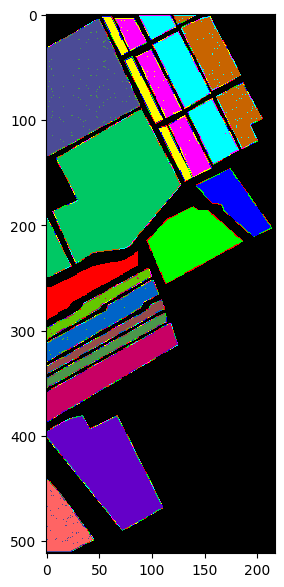

In [38]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

##### Predictions

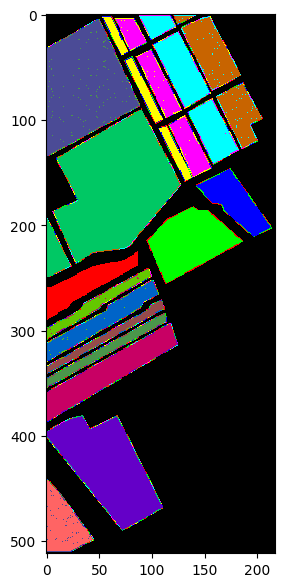

In [39]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))